In [ ]:
#libraries
import torch
import flair
from flair.data import Sentence
import random
import pandas as pd
from flair.datasets import ColumnCorpus
from flair.models import SequenceTagger
from flair.embeddings import WordEmbeddings, StackedEmbeddings,TokenEmbeddings
from typing import List
from flair.tokenization import SegtokSentenceSplitter
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
flair.device

device(type='cuda', index=0)

In [ ]:
# !gcsfuse --implicit-dirs training_data_gtmb colab_direcoty

In [43]:
# ! zip -r reso.zip /content/data/resources/

#Introduction About Span Detection

In NLP Span detection is the process where we identify certain pre-defined pattern of text like detecting questions from emails, or even propaganda from articles. An example:

https://link.springer.com/chapter/10.1007/978-3-030-86523-8_41

Named Entity Recognition is a special case of span detection where we focus on spans of length 2-4 tokens at max.

Context is very important in NER, lets take a look at the example.

Ex: 
1. Apple iphone is a technological marvel

2. Apples are great for health as advised by doctors.

3. 15inch nuts  are required for this power generator to start up

4. You should consume atleast ten gram nuts everyday for a healthy diet.


#Why is it necessary to know it?

Span detection and more commonly NER is one of the basic tasks in combination with classification and question asnwering. If used effectively span detection is able to solve problems like:

1. Identifying feature requests from customer reviews

2. Identifying subtle question remarks from customer emails, this is useful for sales teams who face plethora of questions from customers and find it hard to keep a track.

3. NER and custom ners

Example Feature Request: 

As a final aside, IMHO, the worst perpetrators in this new rental model are the 

*Tax Preparation Software companies that do not clearly document what schedules are included in their entry/base rental price OR their entry/base purchase software*. 

Only after you get started, do you discover that you have to pay a lot extra to get the one schedule that was not included. Imagine seeing that
 *Schedule C is included but later you discover that it is only for Schedule C to enter income, you have to pay more if you want a Schedule C to include expenses*. 
 
 Oh, you can enter the expenses by hand, but then the company will not file your tax return that was part of your purchase price: you have to print the return and mail it in. Fortunately, I knew better than to buy anything so woefully described. Unfortunately, I had to buy a version of the software that included many more features than I needed just to be able to get Schedule C expenses AND free electronic filing.



Sample Email Back To Sales Rep:

Hi Mike,

I really the idea, but does Microsoft has integration on LinkedIn Platform. When is a good time to connect with you. 

Best


#Prerequisites

1. Basic NLP

2. Pytorch

3. Flask

4. Neural networks in particular LSTMs

5. Python libraries pandas, numpy

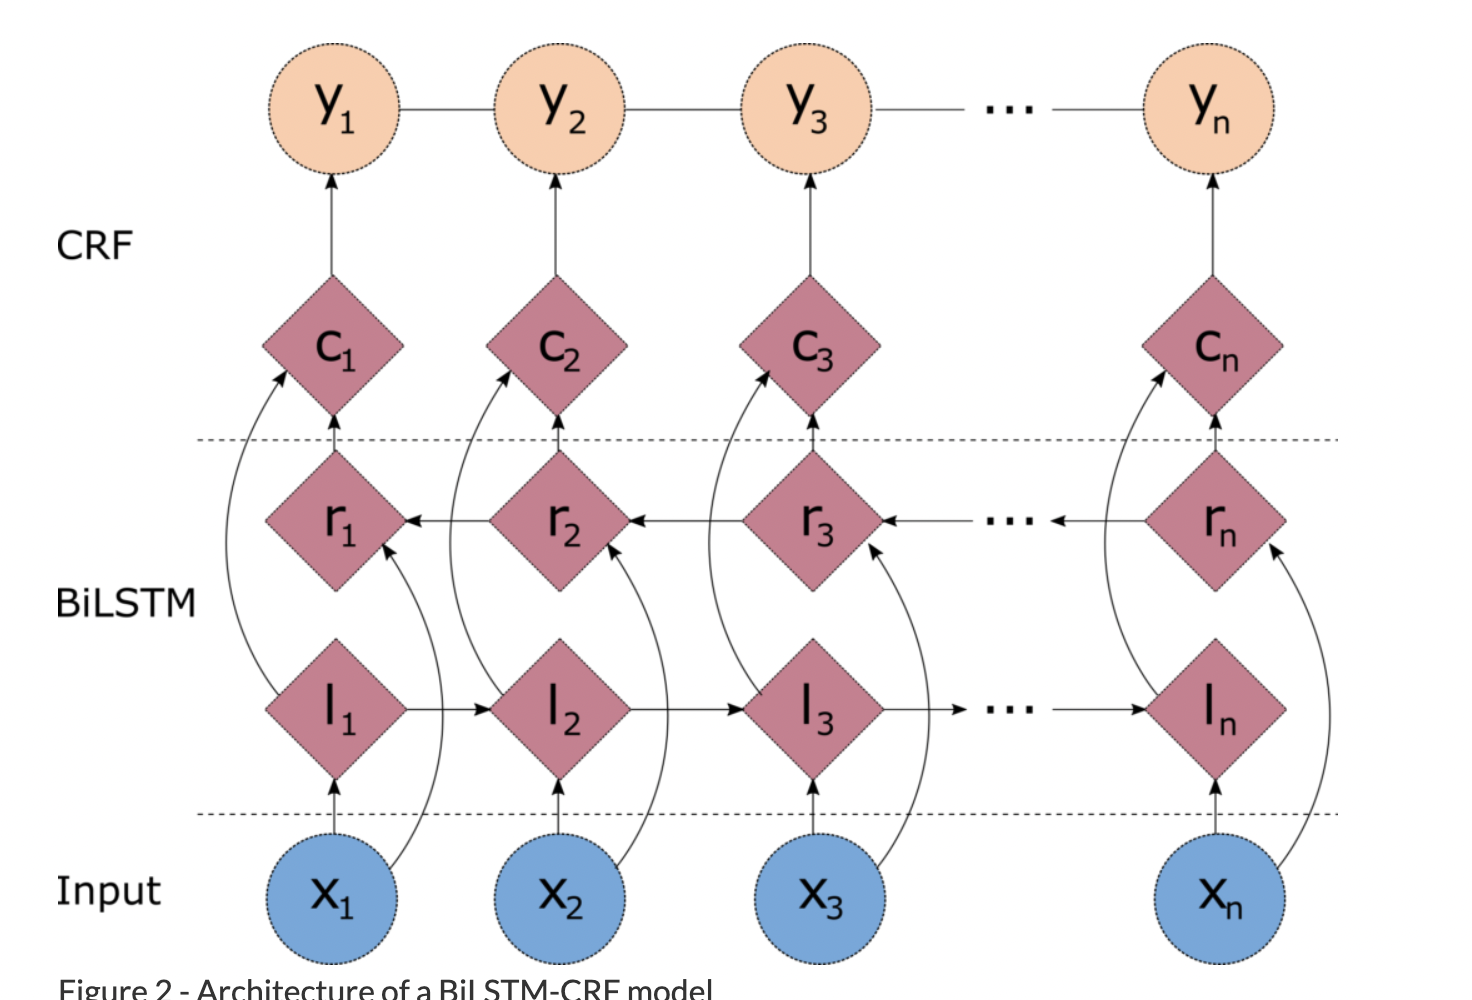

In [42]:
from IPython.display import Image
Image('/content/data/bilstm.png')

#SOTA

https://paperswithcode.com/sota/named-entity-recognition-ner-on-conll-2003




#Steps We Will Cover
1. Understanding tagging -- BIO(ConLL) with doccano
2. Training -- BiLSTM+CRF

3. Test on few sentences -- model outputs
4. API requests --flask

5. Mlflow

https://nlp.johnsnowlabs.com/docs/en/mlflow

https://spark.apache.org/

In [ ]:
# a look at the data
tagger = SequenceTagger.load('ner-ontonotes')
data = pd.read_csv("/content/data/ner.csv")
data.columns = ["Sent","Word","Tag","POS"]
data = data[["Sent","Word","Tag"]]
data.head(5)

2022-10-14 01:31:05,483 loading file /root/.flair/models/en-ner-ontonotes-v0.4.pt


,Sent,Word,Tag
0,1,Thousands,O
1,1,of,O
2,1,demonstrators,O
3,1,have,O
4,1,marched,O


In [ ]:
#divide into train test dev
list_id=data["Sent"].values.tolist()
set_listid=set(list_id)

training_count=int((80*len(set_listid)) /100)
dev_count= int((10*len(set_listid)) /100)
test_count = len(set_listid) - training_count - dev_count

training_count,dev_count,test_count

(28141, 3517, 3519)

In [ ]:
#Divide id's into training, test, and dev set


unique_list = list(set_listid)

random.shuffle(unique_list)

train_data_id = unique_list[:training_count]
dev_data_id = unique_list[training_count:training_count+dev_count]
test_data_id = unique_list[training_count+dev_count:]

In [ ]:
# Script to fetch data and write in flair format

def write_data(li,file):
    wr = open(file,'w')
    
    for id_line in li:
        filter_df = data.loc[data["Sent"]==id_line]
        
        ph=filter_df.Word.values.tolist()
        an=filter_df.Tag.values.tolist()
        
        i=0
        while i < len(ph):
            string = ph[i]+" "+an[i]+"\n"
            wr.write(string)
            i=i+1
        wr.write("\n")
    
    wr.close()

write_data(train_data_id,"/content/data/train.txt")
write_data(test_data_id,"/content/data/test.txt")
write_data(dev_data_id,"/content/data/dev.txt")

In [44]:
# https://docs.google.com/spreadsheets/d/1C8BxVgz25VmTbXXExbgXs2IiRNxhiUMriBlO2UhNrjQ/edit?usp=sharing

In [ ]:
columns = {0 : 'text', 1 : 'ner'}
# directory where the data resides
data_folder = '/content/data/'
# initializing the corpus
Corpus = ColumnCorpus(data_folder, columns,
                              train_file = 'train.txt',
                              test_file = 'test.txt',
                              dev_file = 'dev.txt')
    
print(len(Corpus.train))

print(Corpus.train[0].to_tagged_string('ner'))

2022-10-14 01:32:17,980 Reading data from /content/data
2022-10-14 01:32:17,982 Train: /content/data/train.txt
2022-10-14 01:32:17,984 Dev: /content/data/dev.txt
2022-10-14 01:32:17,985 Test: /content/data/test.txt
28141
Tidal waves caused by the massive Asian earthquake have killed at least 10 people on Africa <B-geo> 's east coast with a number of other tourists and residents reported missing .


In [ ]:
# tag to predict
tag_type = 'ner'
# make tag dictionary from the corpus
tag_dictionary = Corpus.make_tag_dictionary(tag_type=tag_type)

# custom_embedding = WordEmbeddings('en')

word_embeddings = [ WordEmbeddings('en')]
embedding_types : List[TokenEmbeddings] = word_embeddings
embeddings : StackedEmbeddings = StackedEmbeddings(
                                 embeddings=embedding_types)

In [ ]:
from flair.models import SequenceTagger
tagger : SequenceTagger = SequenceTagger(hidden_size=256,
                                       embeddings=embeddings,
                                       tag_dictionary=tag_dictionary,
                                       tag_type=tag_type,
                                       use_crf=True)
print(tagger)

SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings('en')
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=300, out_features=300, bias=True)
  (rnn): LSTM(300, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=21, bias=True)
  (beta): 1.0
  (weights): None
  (weight_tensor) None
)


In [16]:
from flair.trainers import ModelTrainer
trainer : ModelTrainer = ModelTrainer(tagger, Corpus)
trainer.train('/content/data/',
              learning_rate=0.1,
              mini_batch_size=32,
              max_epochs=100)

2022-10-14 01:33:20,591 ----------------------------------------------------------------------------------------------------
2022-10-14 01:33:20,593 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings('en')
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=300, out_features=300, bias=True)
  (rnn): LSTM(300, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=21, bias=True)
  (beta): 1.0
  (weights): None
  (weight_tensor) None
)"
2022-10-14 01:33:20,594 ----------------------------------------------------------------------------------------------------
2022-10-14 01:33:20,595 Corpus: "Corpus: 28141 train + 3517 dev + 3519 test sentences"
2022-10-14 01:33:20,597 ----------------------------------------------------------------------------------------------------
2022-10-14 01:33:20,598 Parameters:
2022-10-14 01:33:20,599  - learning_

{'dev_loss_history': [3.5585978031158447,
  3.2918548583984375,
  2.8842110633850098,
  2.6599481105804443,
  2.5277388095855713,
  2.4436700344085693,
  2.4643054008483887,
  2.4196057319641113,
  2.2975881099700928,
  2.264221429824829,
  2.2581124305725098,
  2.2239742279052734,
  2.2496864795684814,
  2.1674280166625977,
  2.1785216331481934,
  2.1233391761779785,
  2.1006274223327637,
  2.093273162841797,
  2.062591791152954,
  2.048696517944336,
  2.088829278945923,
  2.0730369091033936,
  2.0207338333129883,
  2.0105435848236084,
  2.0142931938171387,
  1.972840666770935,
  2.0075714588165283,
  1.9814941883087158,
  1.951151967048645,
  1.9345775842666626,
  1.9110625982284546,
  1.9140620231628418,
  1.9148662090301514,
  1.9126800298690796,
  1.9226216077804565,
  1.897682785987854,
  1.8828999996185303,
  1.8859615325927734,
  1.8860877752304077,
  1.896260380744934,
  1.8973215818405151,
  1.8908079862594604,
  1.8729279041290283,
  1.871727705001831,
  1.8661881685256958,


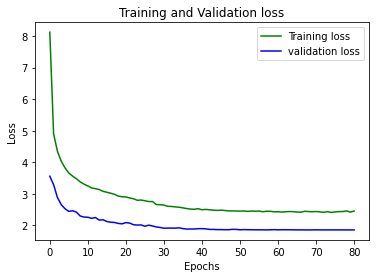

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
loss_df = pd.read_csv("/content/data/loss.tsv",sep="\t")
# loss_df.head(3)

loss_train = loss_df['TRAIN_LOSS']
loss_val = loss_df['DEV_LOSS']
# f1_acc = loss_df['DEV_F1']
epochs = range(0,81)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
# plt.plot(epochs, f1_acc, 'r', label='f1 acc')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
#prediction
from flair.data import Sentence
from flair.models import SequenceTagger
# load the trained model
model = SequenceTagger.load('/content/data/best-model.pt')
# create example sentence
sentence = Sentence('Thousands gathered at Times Square to protest among them was Tom Cruise also')
# sentence2 = Sentence('Lets meet at Chilman Square to protest with Hrisabh Singh')

# predict the tags
model.predict(sentence)
# model.predict(sentence2)


2022-10-14 22:16:12,240 loading file /content/data/best-model.pt


In [21]:
# ! pip freeze|grep flair

In [22]:
# model.predict(sentence2)


In [51]:
sentence.get_spans()

[<org-span (4,5): "Times Square">, <per-span (11,12): "Tom Cruise">]

In [52]:
sentence3 = Sentence('Lets meet at Jhgahg Square to protest with Hsdjhds Singh')


In [53]:
model.predict(sentence3)
sentence3.get_spans()

[<geo-span (4,5): "Jhgahg Square">, <per-span (9,10): "Hsdjhds Singh">]